<a href="https://colab.research.google.com/github/Mahnazshamissa/Python/blob/main/Random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, f1_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, plot_precision_recall_curve
from sklearn.model_selection import train_test_split

In [7]:
abo_path = '/content/WA_Fn-UseC_-Telco-Customer-Churn.csv'
p_df_raw = pd.read_csv(abo_path, sep=',', encoding="UTF-8")

In [8]:
p_df_raw.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


In [9]:
p_df_raw.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

# **Transform the data: make every column into number and scale the values of each column**

In [12]:
df_y = p_df_raw['Churn']
df_y = pd.DataFrame(LabelEncoder().fit_transform(df_y))
df_y = df_y.reset_index(drop=True)

df_X_raw = p_df_raw.drop(['customerID', 'Churn'], axis=1)
#df_X_raw = p_df_raw_train.drop(['Name'], axis=1)

columns=df_X_raw.columns
for f in df_X_raw.columns:
    if df_X_raw[f].dtype == 'object':
        df_X_raw[f] = LabelEncoder().fit_transform(list(df_X_raw[f]))

In [13]:
scaler = PowerTransformer()
scaled_df = scaler.fit_transform(df_X_raw)
df_X = pd.DataFrame(scaled_df, columns=columns)
df_X = df_X.reset_index(drop=True)

In [14]:
class_labels = np.unique(df_y)
class_weights = compute_class_weight('balanced', class_labels, df_y)
class_weights = dict(zip(class_labels, class_weights))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
class_weights

{0: 0.6806146115191342, 1: 1.8841626538255751}

In [16]:
df_X.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y)

# **Random Forest initializer**

In [18]:
clf = RandomForestClassifier(
    n_estimators=50,
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)

# **training with CV**

In [31]:
train_auc_list = []
valid_auc_list = []

fprs, tprs, scores = [], [], []

cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)


for train_index, val_index in cv.split(X_train, y_train):
    X_train_sub, X_valid_sub = X_train.loc[X_train.index[train_index]], X_train.loc[X_train.index[val_index]]
    y_train_sub, y_valid_sub = y_train.loc[y_train.index[train_index]], y_train.loc[y_train.index[val_index]]
    
    print(type(y_train_sub),y_train_sub.shape)

    #print(type(y_train_sub.values),y_train_sub.shape())
    clf.fit(X_train_sub, y_train_sub.values[:,0])  #[0].ravel())
    clf_pred_train = clf.predict(X_train_sub)
    clf_pred_val = clf.predict(X_valid_sub)
            
    train_f1 = round(f1_score(clf_pred_train, y_train_sub), 8)*100
    valid_f1 = round(f1_score(clf_pred_val, y_valid_sub), 8)*100
        
    scores.append((train_f1, valid_f1))   
    train_auc_list.append(train_f1)
    valid_auc_list.append(valid_f1)

<class 'pandas.core.frame.DataFrame'> (4225, 1)
<class 'pandas.core.frame.DataFrame'> (4225, 1)
<class 'pandas.core.frame.DataFrame'> (4226, 1)
<class 'pandas.core.frame.DataFrame'> (4226, 1)
<class 'pandas.core.frame.DataFrame'> (4226, 1)


In [32]:
pd.DataFrame(scores, columns=['F1 Train', 'F1 Val'])

,F1 Train,F1 Val
0,64.714185,63.202247
1,64.828561,65.915493
2,64.812834,61.939219
3,64.749211,62.253521
4,65.211167,61.797753


# **Predicting on test data**

In [21]:
clf_test_pred = clf.predict(X_test)

In [22]:
auc_test = roc_auc_score(y_test, clf_test_pred)
test_f1 = round(f1_score(y_test, clf_test_pred), 8)*100
print('\nAUROC:',auc_test, ", F1 score:", test_f1)


AUROC: 0.7382008676434477 , F1 score: 60.15037600000001


In [23]:
fpr, tpr, threshold = roc_curve(y_test, clf_test_pred)

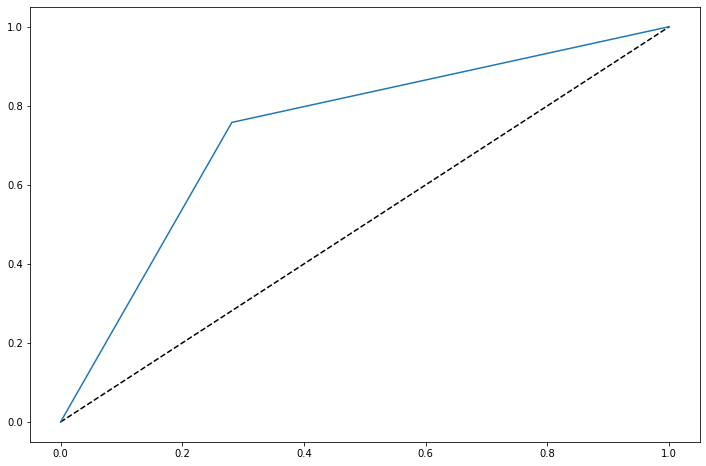

In [24]:
fig = plt.figure(figsize=(12,8)) 
ax = fig.add_subplot(1,1,1)
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr, tpr);

In [25]:
print('Accuracy')
print(accuracy_score(y_test, clf_test_pred))
print('Confusion Matrix')
print(confusion_matrix(y_test, clf_test_pred))
print('Confusion Report')
print(classification_report(y_test, clf_test_pred))

Accuracy
0.7291311754684838
Confusion Matrix
[[924 362]
 [115 360]]
Confusion Report
              precision    recall  f1-score   support

           0       0.89      0.72      0.79      1286
           1       0.50      0.76      0.60       475

    accuracy                           0.73      1761
   macro avg       0.69      0.74      0.70      1761
weighted avg       0.78      0.73      0.74      1761

